Number of Samples:  3072
Number of Antennas:  24
(800,)
(800,)
(128, 128)
(128, 128)
(16384,)


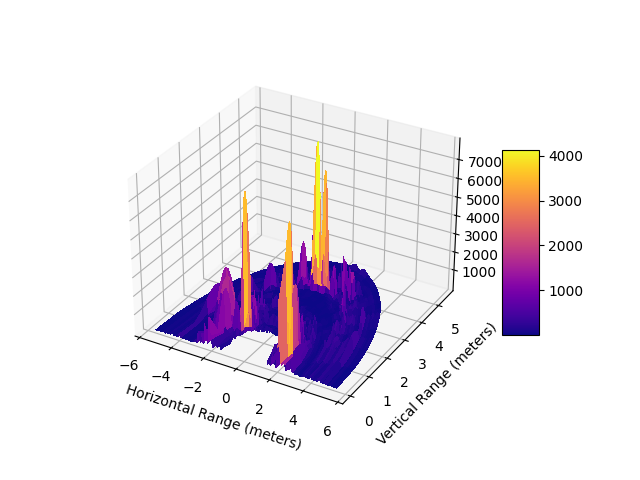

In [1]:
import json
import matplotlib.pyplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import cv2
from  scipy.interpolate import griddata
from matplotlib import transforms
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Allows for plot manipulation like rotation
%matplotlib ipympl

# Turn parsed JSON file into dictionary
file_str = "../data/Demo/fog/cornercube_faraway/parsed.json" # JSON File Address 
file = open(file_str)
data_dict = json.load(file)

read_message = -1 # Depends from file to file / Choose Data Stream Type (e.g. Azimuth, Doppler, Point Cloud)
read_body = 1    # Depends from file to file / Choose which frame of data to choose (Depends on recording duration)
# use body 1 for fog folder

# Declaring Variables
antenna_range = 5.58  # Depends on the range set in the mmwave OOB demo plots tab above sensor start/stop
start_range_bin = 32
azimuth_data = data_dict["messages"][read_message]["body"][read_body]["body"]["data"]

# print(azimuth_data) # to check body structure

range_bins = 128 # never changes
angle_bins = range_bins

num_sample = np.shape(azimuth_data[:])[0] # calculates number of samples
print("Number of Samples: ",num_sample)

num_antenna = int(num_sample/128) # number of virtual RX antennas, usually 8-12
# 4 virtual RX antennas for each TX antenna used
print("Number of Antennas: ",num_antenna)

# Prepare vectors for the real and imaginary values
real_power = np.zeros([num_sample], dtype=np.complex_)
imag_power = np.zeros([num_sample], dtype=np.complex_)
for i in (range(num_sample)):
    real_power[i] = azimuth_data[i]["Re"]
    imag_power[i] = azimuth_data[i]["Im"]*1j

# Combine values
complex_power = real_power + imag_power

# Construct Radar Cube by reshaping vector into a matrix size: number range bins x number of antennas 
antenna_vs_power = np.reshape(complex_power, (range_bins, num_antenna))

angle_FFT = np.fft.fft(antenna_vs_power,angle_bins,1) #FFT along 2nd Dimension, not range bins
angle_FFT = np.abs(np.fft.fftshift(angle_FFT,1)) #Shifts FFT so 0 frequency element is in the center
angle_FFT = cv2.transpose(angle_FFT)
angle_FFT = cv2.transpose(angle_FFT) # Comment out when using heatmap

# For plotting purposes
##########################################################################

range_res = antenna_range / range_bins
range_bias = 0

theta = np.arange(-1, 1 + 2 / (angle_bins) , 2 / (angle_bins-1))
#print(theta)
#print(theta.shape)
theta = np.arcsin(theta) # t * ((1 + np.sqrt(5)) / 2)
#print(theta)
range = np.array(range(range_bins)) * range_res

range_depth = range_bins * range_res
range_width, grid_res = range_depth / 2, 800

xi = np.linspace(-range_width, range_width, grid_res)
yi = np.linspace(0, range_depth, grid_res)
xii, yii = np.meshgrid(xi, yi)
print(np.shape(xi))
print(np.shape(yi))

x = np.array([range]).T * np.sin(theta)
y = np.array([range]).T * np.cos(theta)

print(np.shape(x))
print(np.shape(y))

points = np.array((x.flatten(), y.flatten())).T
values = np.array((angle_FFT, )).T
values = values.flatten()
print(np.shape(values))
Z = griddata(points
             ,values
             ,(xii,yii),"linear")
#######################################################################


# Creates Heatmap with Relative Power as the color

# fig = plt.figure(figsize =(9, 7))
# ax = fig.add_subplot(111)
# image = cv2.flip(Z,0)
# img = ax.imshow((image)
#           #, transform=tr + ax.transData
#           ,extent=[-antenna_range/2,antenna_range/2,0,antenna_range]
#           )
# ax.set_xlabel("Horizontal Range (meters)")
# ax.set_ylabel("Vertical Range (meters)")
# cbar = fig.colorbar(img, ax=ax)
# cbar.set_label('Relative Power',size=18)
# plt.show()


# Creates 3D surface with Relative Power in the Z - axis

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(x[start_range_bin:-1], y[start_range_bin:-1], angle_FFT[start_range_bin:-1], cmap=cm.plasma,
                       linewidth=0, antialiased=False)
ax.set_xlabel("Horizontal Range (meters)")
ax.set_ylabel("Vertical Range (meters)")
ax.set_zlabel("Relative Power")

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()
